In [16]:
!pip uninstall sompy -y

Found existing installation: sompy 0.1.1
Uninstalling sompy-0.1.1:
  Successfully uninstalled sompy-0.1.1


In [17]:
!git clone https://github.com/sevamoo/SOMPY.git

fatal: destination path 'SOMPY' already exists and is not an empty directory.


In [18]:
!pip install ipdb
!pip install numexpr

In [19]:
import sys
sys.path.append('/content/SOMPY')  # Add the SOMPY folder to the Python path

import sompy  # Now you can import sompy

In [27]:
from IPython.display import YouTubeVideo

from os.path import join
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier

from sompy.sompy import SOM
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
from sklearn.preprocessing import StandardScaler

In [22]:
df=pd.read_csv('df_PCA.csv',delimiter=',')

In [23]:
df.set_index('customer_id',inplace=True)

A saída de streaming foi truncada nas últimas 5000 linhas.
 epoch: 142 ---> elapsed time:  0.011000, quantization error: 1.122824

 epoch: 143 ---> elapsed time:  0.012000, quantization error: 1.122824

 epoch: 144 ---> elapsed time:  0.013000, quantization error: 1.122824

 epoch: 145 ---> elapsed time:  0.011000, quantization error: 1.122824

 epoch: 146 ---> elapsed time:  0.012000, quantization error: 1.122824

 epoch: 147 ---> elapsed time:  0.014000, quantization error: 1.122824

 epoch: 148 ---> elapsed time:  0.007000, quantization error: 1.122824

 epoch: 149 ---> elapsed time:  0.011000, quantization error: 1.122824

 epoch: 150 ---> elapsed time:  0.017000, quantization error: 1.122824

 epoch: 151 ---> elapsed time:  0.012000, quantization error: 1.122824

 epoch: 152 ---> elapsed time:  0.013000, quantization error: 1.122824

 epoch: 153 ---> elapsed time:  0.013000, quantization error: 1.122824

 epoch: 154 ---> elapsed time:  0.010000, quantization error: 1.122824

 epoc

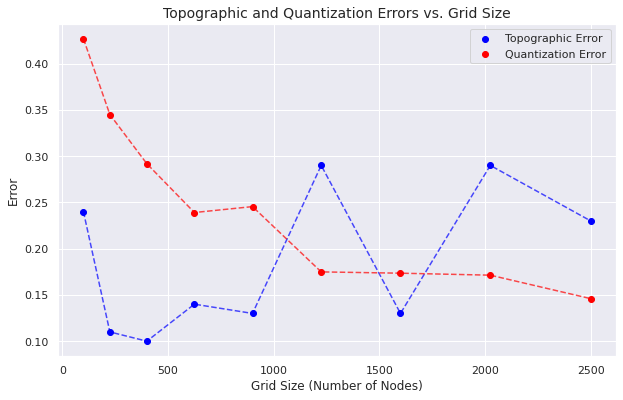

In [36]:
grid_sizes = [(10, 10), (15, 15), (20, 20), (25, 25), (30, 30),(35,35),(40,40),(45,45),(50,50)]
#

# Lists to store errors
topographic_errors = []
quantization_errors = []

# Train SOM for each grid size and record errors
for size in grid_sizes:
    sm = sompy.SOMFactory().build(
        df.values,
        mapsize=size,
        initialization='random',
        neighborhood='gaussian',
        training='batch',
        lattice='hexa'
    )
    sm.train(n_job=1, verbose='info', train_rough_len=100, train_finetune_len=200)

    # Collect errors
    topographic_errors.append(sm.calculate_topographic_error())
    quantization_errors.append(sm.calculate_quantization_error())

# Plotting
grid_sizes_flat = [s[0] * s[1] for s in grid_sizes]  # Flatten grid sizes into single values

plt.figure(figsize=(10, 6))

# Topographic error scatter plot
plt.scatter(grid_sizes_flat, topographic_errors, label="Topographic Error", color="blue")
plt.plot(grid_sizes_flat, topographic_errors, color="blue", linestyle="--", alpha=0.7)

# Quantization error scatter plot
plt.scatter(grid_sizes_flat, quantization_errors, label="Quantization Error", color="red")
plt.plot(grid_sizes_flat, quantization_errors, color="red", linestyle="--", alpha=0.7)

# Labels and Legend
plt.title("Topographic and Quantization Errors vs. Grid Size", fontsize=14)
plt.xlabel("Grid Size (Number of Nodes)", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [37]:
np.random.seed(42)

sm = sompy.SOMFactory().build(
    df.values,
    mapsize=[30, 30],
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=df.columns
)
sm.train(n_job=4, verbose='info', train_rough_len=100, train_finetune_len=1000)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 10.000000 , radius_final: 1.666667, trainlen: 100

 epoch: 1 ---> elapsed time:  0.043000, quantization error: 0.082867

 epoch: 2 ---> elapsed time:  0.043000, quantization error: 2.176233

 epoch: 3 ---> elapsed time:  0.048000, quantization error: 2.143722

 epoch: 4 ---> elapsed time:  0.060000, quantization error: 2.139946

 epoch: 5 ---> elapsed time:  0.052000, quantization error: 2.136805

 epoch: 6 ---> elapsed time:  0.045000, quantization error: 2.134334

 epoch: 7 ---> elapsed time:  0.057000, quantization error: 2.132371

 epoch: 8 ---> elapsed time:  0.058000, quantization error: 2.129872

 epoch: 9 ---> elapsed time:  0.046000, quantization error: 2.126209

 epoch: 10 ---> elapsed time:  0.052000, quantization error: 2.122795

 epoch: 11 ---> elapsed time:  0.048000, quantization error: 2.120167

 epoch: 12 ---> elapsed time:  0.052000, quantization error: 2.116822

 epoch: 13 --->

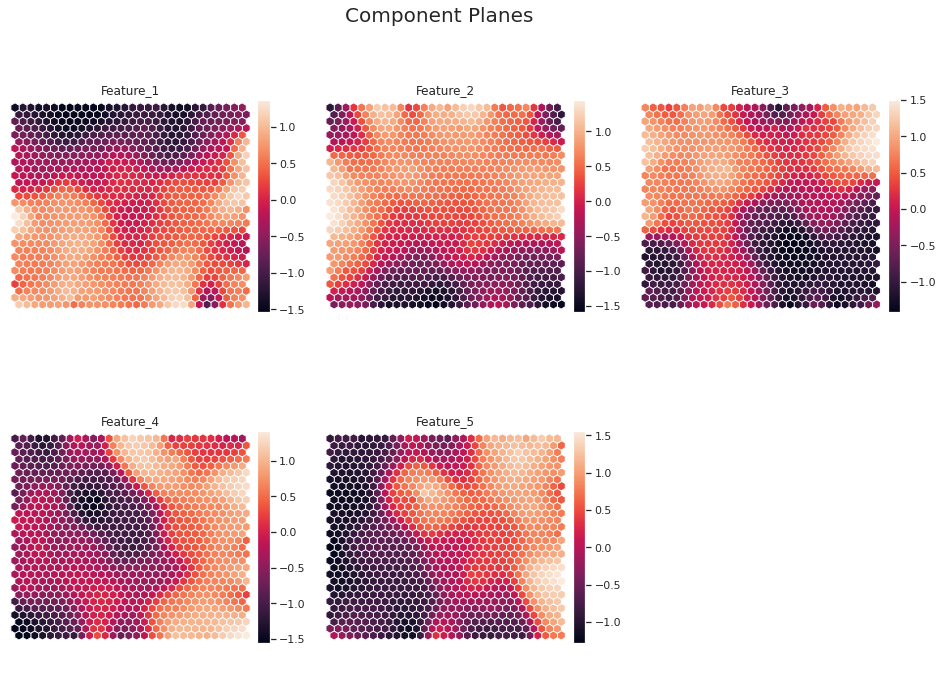

In [33]:
plt.rcParams['figure.dpi'] = 72


# Visualizing the Component planes (feature values)
sns.set()
view2D = View2D(12, 12, "", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

In [ ]:
x=int(np.sqrt(5*np.sqrt(df.shape[0])))
y=x
input_len=df.shape[1]

In [ ]:
space={'sig':hp.uniform('sig',0.01,x/2.01),'learning_rate':hp.uniform('learning_rate',0.001,0.8)}
def son_fn(space):
  sig=space['sig']
  lr=space['learning_rate']
  val=MiniSom(x=x,y=y,input_len=input_len,sigma=sig,learning_rate=lr).quantization_error(df.values)
  return {'loss': val,'status':STATUS_OK}
trials = Trials()
best=fmin(fn=son_fn,space=space,algo=tpe.suggest,max_evals=200,trials=trials)
print('best:',format(best))

100%|██████████| 200/200 [01:49<00:00,  1.83trial/s, best loss: 1.218626099266434]
best: {'learning_rate': 0.48282222628042604, 'sig': 1.006560378937622}


In [ ]:
sigma=best['sig']
learning_rate=best['learning_rate']